In [150]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns

from jax.nn import softmax
from jax.config import config
from pathlib import Path
from collections import namedtuple

config.update('jax_platform_name', 'cpu')
np.set_printoptions(precision=4)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 18})

from grl.utils import load_info
from grl.utils.data import uncompress_episode_rewards

from definitions import ROOT_DIR

In [116]:
results_dir_td = Path(ROOT_DIR, 'results', 'rnn_reruns_td')
results_dir_mc = Path(ROOT_DIR, 'results', 'rnn_reruns_mc')

In [123]:

offline_eval = []
all_results_paths = list(results_dir_td.iterdir()) + list(results_dir_mc.iterdir())

for results_path in tqdm(all_results_paths):
    if results_path.is_dir() or results_path.suffix != '.npy':
        continue
    
    info = load_info(results_path)
    args = info['args']
    
    if (args['multihead_loss_mode'] != 'both') and (args['multihead_lambda_coeff'] > 0.):
        continue

    offline_evals = info['episodes_info']['offline_eval']
    eval_freq = args['offline_eval_freq']
    total_steps = args['total_steps']
    
    all_t_undisc_returns = []
    for i, oe in enumerate(offline_evals):
        d = {**args}
        
        avg_undisc_returns = 0
        for ep in oe['episode_rewards']:
            episode_rewards = np.array(uncompress_episode_rewards(ep['episode_length'], ep['most_common_reward'], ep['compressed_rewards']))

            # TODO: calculate value estimation error through q_t - g_t
            undisc_returns = episode_rewards.sum()
            avg_undisc_returns += undisc_returns

        avg_undisc_returns /= len(oe['episode_rewards'])
        d['timestep'] = int(i * eval_freq)
        d['undisc_returns'] = undisc_returns
    
        offline_eval.append(d)

offline_eval_df = pd.DataFrame(offline_eval)

  0%|          | 0/1920 [00:00<?, ?it/s]

In [124]:
offline_lstm_eval_df = offline_eval_df[
    (offline_eval_df['arch'] == 'lstm') & 
    (offline_eval_df['multihead_lambda_coeff'] >= 0.)
                                      ]
unique_seeds = offline_lstm_eval_df.seed.unique()

split_by_args = ['spec', 'multihead_action_mode', 'multihead_loss_mode', 'multihead_lambda_coeff', 'timestep']
lstm_grouped = offline_lstm_eval_df.groupby(split_by_args, as_index=False)

In [125]:
# take mean and std_err over mean over seeds
lstm_mean = lstm_grouped.mean(numeric_only=True)
lstm_sem = lstm_grouped.sem(numeric_only=True)
# lstm_res['undisc_returns_means'] = lstm_grouped.undisc_returns.apply(lambda g: g.mean())
# lstm_res['undisc_returns_std_err'] = lstm_grouped.undisc_returns.agg(np.stack)['undisc_returns'].apply(lambda g: g.std(axis=0) / np.sqrt(g.shape[0]))


In [153]:
all_labels = \
    ['_'.join([str(el) for el in row]) for row in offline_lstm_eval_df[[arg for arg in split_by_args if (arg != 'spec') and (arg != 'timestep')]]\
        .drop_duplicates()\
        .to_numpy()]

label_cmap = {}

color = iter(cm.tab10(np.linspace(0, 1, 10)))
for i in range(len(all_labels)):
    c = next(color)
    label_cmap[all_labels[i]] = c

  0%|          | 0/8 [00:00<?, ?it/s]

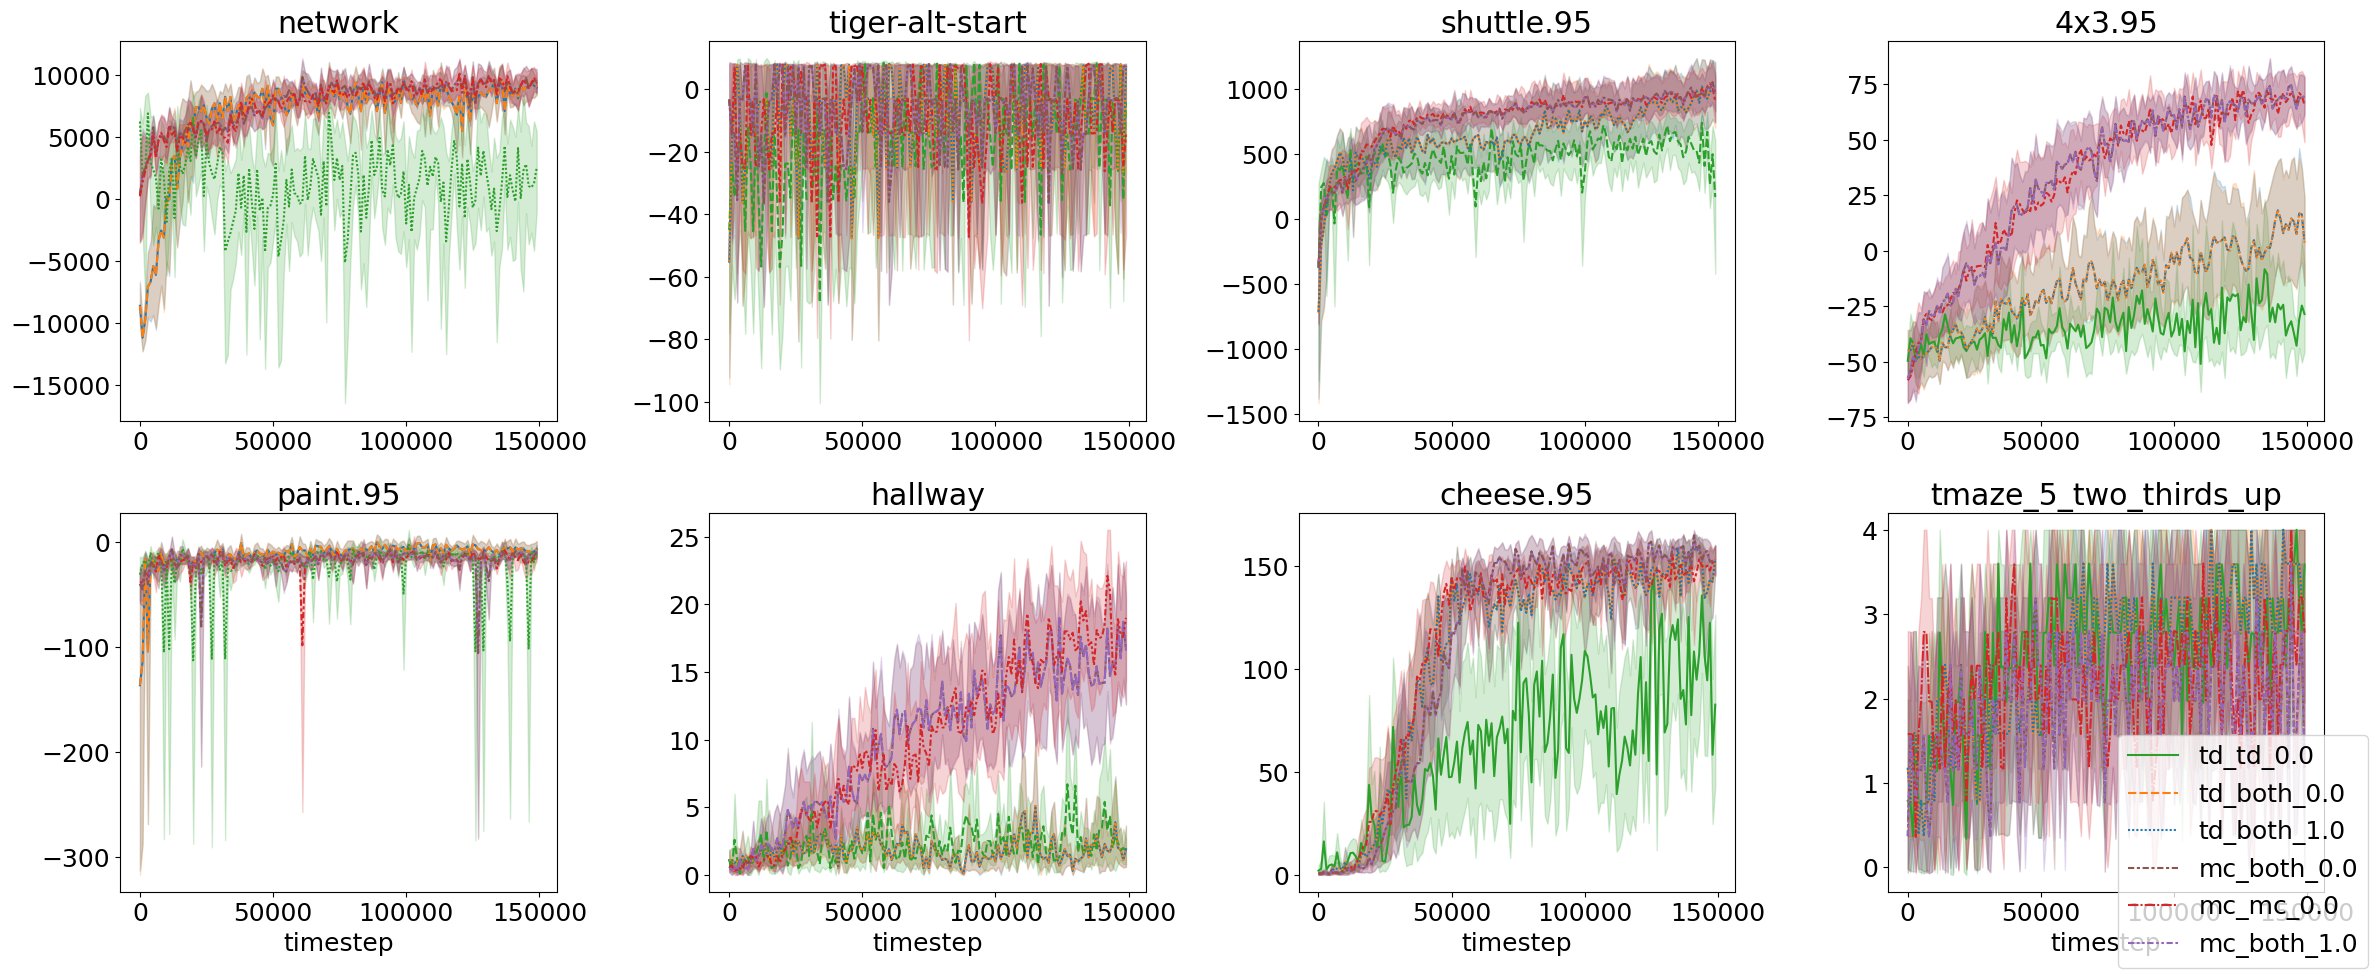

In [158]:
df = offline_lstm_eval_df
pivot_value_key = 'undisc_returns'

spec_strs = df['spec'].unique()

pivot_cols = [arg for arg in split_by_args if (arg != 'spec') and (arg != 'timestep')] + ['seed']

n_rows, n_cols = 2, np.ceil(len(key_vals) / 2).astype(int)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 10))

for i, spec in tqdm(list(enumerate(spec_strs))):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    spec_df = df[df['spec'] == spec]
    
    # Make a pivot table
    pivot_df = spec_df.pivot(index='timestep', columns=pivot_cols, values=pivot_value_key)
    
    # Flatten all columns except seed
    col_name = '_'.join([col for col in pivot_cols if col != 'seed'])
    multi_index = pd.MultiIndex.from_tuples([('_'.join([str(c) for c in col[:-1]]), col[-1]) for col in pivot_df.columns], names=[col_name, "seed"])

    pivot_df.columns = multi_index

    sns.lineplot(ax=ax, data=pivot_df, palette=label_cmap)
    
    ax.get_legend().remove()
    ax.set_title(spec)
    if col > 0:
        ax.set_ylabel(None)
    if row < n_rows - 1:
        ax.set_xlabel(None)
        
    handles, labels = ax.get_legend_handles_labels()
    
#     if i >= 1:
#         break
        
fig.legend(handles, labels, loc='lower right')
fig.tight_layout()

In [130]:
np.ceil(0.1).astype(int)

1